In [1]:
#import analysis
import sys
sys.path.insert(0,'../scripts/')

import test_features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import subplots,scatter
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import scipy.stats as stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import cross_val_score
#from yellowbrick.features import RFECV
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost
import h5py

C:\Users\Richard\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#import analysis
def read_data(file_dir,DB_file_dir):
    
    data = []
    label = []
    
    print('loading..{}'.format(file_dir))
    df=pd.read_pickle(file_dir)
    psm_ID=list(pd.read_csv(DB_file_dir)['Scan'])
    y=np.zeros(df.shape[0])

    for i in range(0,df.shape[0]):
        if df.index[i] in psm_ID:
            y[i]=1

    X = df.drop('RT',axis=1).fillna(0).values
    y =y.astype(int)[X.sum(axis=1)!=0]
    X = X[X.sum(axis=1)!=0]
    X = X/X.sum(axis=1).reshape(X.shape[0],1) #normalization
    data.append(X)
    label.append(y)
    del X

    data = np.concatenate((data))
    label = np.concatenate((label))
    return data,label

from numpy.random import randint,seed,choice
def under_sampler(data,label,n_sample):
    
    index_maj = np.where(label==0)[0]
    index_min = np.where(label==1)[0]
    
    seed(19)
    sample_index = choice(len(index_maj),size=n_sample,replace=False)
    index_maj_sampled = index_maj[sample_index]
    data_sampled = data[np.concatenate((index_maj_sampled,index_min))]
    label_sampled = label[np.concatenate((index_maj_sampled,index_min))]
    
    shuffle_index = choice(len(data_sampled),size=len(data_sampled),replace=False)
    data_sampled = data_sampled[shuffle_index]
    label_sampled = label_sampled[shuffle_index]
    
    return data_sampled,label_sampled

def load_sample_data(file_dir,DB_file_dir,file_names,sample_names,n_sample):
    
    X_train,X_test,Y_train,Y_test = [],[],[],[]
    for i in range(len(file_names)):
        data,label = read_data(file_dir+'/'+file_names[i]+'.pkl',DB_file_dir+'/'+sample_names[i]+'/DB search psm.CSV')
        x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=1)
        del data
        
        x_train_sampled,y_train_sampled = under_sampler(x_train,y_train,len(y_train[y_train==1])*n_sample)
        del x_train,y_train
        X_train.append(x_train_sampled)
        #X_test.append(x_test)
        np.save(out_dir+'/'+sample_names[i]+'_test_data',x_test)
        del x_test
        Y_train.append(y_train_sampled)
        #Y_test.append(y_test)
        np.save(out_dir+'/'+sample_names[i]+'_test_label',y_test)
        del y_test,x_train_sampled,y_train_sampled
        
    X_train = np.concatenate(X_train)
    #X_test = np.concatenate(X_test)
    Y_train = np.concatenate(Y_train)
    #Y_test = np.concatenate(Y_test)

    return X_train,X_test,Y_train,Y_test

In [8]:
import utils

def mzml_to_pkl(mzml_dir,pkl_dir,file_names):
    for file_name in file_names:
        print('reading {}'.format(file_name))
        mzml_df = utils.read_mzml(mzml_dir+'/'+file_name+'.mzml')
        print('saving as pickle...')
        mzml_df.to_pickle(pkl_dir+'/'+file_name+'.pkl')
        print('conversion successful')

mzml_dir = '../ML_proteomics/mzml'
pkl_dir = '../ML_proteomics/mzml_converted'
# file_names = ['01075_A01_P010693_S00_N01_R1','01076_A01_P010694_S00_N01_R1',
#              '01088_A01_P010740_S00_N01_R1','01092_A01_P010747_S00_N01_R1',
#              '01093_A01_P010748_S00_N01_R1','01226_A01_P012502_S00_N01_R1',
#              '01269_A01_P013107_S00_N01_R1','01270_A01_P013114_S00_N01_R2',
#              '01275_A03_P013127_S00_N17_R1','01276_A01_P013128_S00_N01_R1']
mzml_to_pkl(mzml_dir,pkl_dir,file_names)

reading 01075_A01_P010693_S00_N01_R1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000


C:\Users\Richard\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




saving as pickle...
conversion successful
reading 01076_A01_P010694_S00_N01_R1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
saving as pickle...
conversion successful
reading 01088_A01_P010740_S00_N01_R1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
saving as pickle...
conversion successful
reading 01092_A01_P010747_S00_N01_R1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
saving as pickle...
conversion successful
reading 01093_A0

In [3]:
file_dir = '../ML_proteomics/mzml_converted'
DB_file_dir = '../ML_proteomics/PSM'
out_dir = '../ML_proteomics/out'
file_names = ['01075_A01_P010693_S00_N01_R1','01076_A01_P010694_S00_N01_R1',
             '01088_A01_P010740_S00_N01_R1','01093_A01_P010748_S00_N01_R1',
              '01226_A01_P012502_S00_N01_R1','01276_A01_P013128_S00_N01_R1']
sample_names = ['P010693','P010694','P010740','P010748',
               'P012502','P013128']
#X_train,X_test,Y_train,Y_test = load_sample_data(file_dir,DB_file_dir,file_names,sample_names,2)

In [4]:
np.save(out_dir+'/train_data_5_set_x2.npy',X_train)
np.save(out_dir+'/train_label_5_set_x2.npy',Y_train)

In [5]:
#training GBT

scale_weight = Y_train[Y_train==0].shape[0]/Y_train[Y_train==1].shape[0]

xgb_best = xgboost.XGBClassifier(learning_rate=0.1, n_estimators=600, objective='binary:logistic',scale_pos_weight=scale_weight,
                    subsample=1,reg_alpha=0,min_child_weight=5,max_depth=4,gamma=0,colsample_bytree=1,nthread = 8)

xgb_best.fit(X_train,Y_train)
joblib.dump(xgb_best, '../models/xgboost_sampled_humandata_5_set_x2.pkl') 

['../models/xgboost_sampled_humandata_5_set_x2.pkl']

In [25]:
PROB = []
REPORT = []
Y_test = []
xgb_best=joblib.load('../models/xgboost_sampled_x2_data.pkl')
for i in range(len(sample_names)):
    test_data_dir = out_dir+'/'+sample_names[i]+'_test_data.npy'
    test_label_dir = out_dir+'/'+sample_names[i]+'_test_label.npy'

    print('predicting..'+test_data_dir)
    data = np.load(test_data_dir)
    label = np.load(test_label_dir)
    Y_test.append(label)
    y_pred_xgb_best = xgb_best.predict(data)
    PROB.append(xgb_best.predict_proba(data))
    REPORT.append(classification_report(label, y_pred_xgb_best, output_dict=True))
Y_test = np.concatenate(Y_test)
y_pred_xgb_prob_best_ = np.concatenate(PROB)

predicting..../ML_proteomics/out/P010693_test_data.npy
predicting..../ML_proteomics/out/P010694_test_data.npy
predicting..../ML_proteomics/out/P010740_test_data.npy
predicting..../ML_proteomics/out/P010748_test_data.npy
predicting..../ML_proteomics/out/P012502_test_data.npy
predicting..../ML_proteomics/out/P013128_test_data.npy


In [4]:
#Loading trained DL model

import os
cuda_path = 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.0\\bin'
cudnn_path = 'D:\\Work\\software\\cuda\\bin'
os.environ["PATH"] += os.pathsep + cuda_path
os.environ["PATH"] += os.pathsep + cudnn_path
import keras
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)
import keras
from keras.layers import Dense, Conv1D, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling1D, AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

INTERESTING_CLASS_ID =  1 # Choose the class of interest

def single_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, INTERESTING_CLASS_ID), 'int32')
    #recall_mask = K.cast(K.equal(class_id_true, INTERESTING_CLASS_ID), 'int32')

    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    #class_recall_tensor = K.cast(K.equal(class_id_true, class_id_true), 'int32') * recall_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    #class_recall = K.sum(class_recall_tensor) / K.maximum(K.sum(recall_mask), 1)
    return class_acc

def single_class_recall(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    #accuracy_mask = K.cast(K.equal(class_id_preds, INTERESTING_CLASS_ID), 'int32')
    recall_mask = K.cast(K.equal(class_id_true, INTERESTING_CLASS_ID), 'int32')

    #class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_recall_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * recall_mask
    #class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    class_recall = K.sum(class_recall_tensor) / K.maximum(K.sum(recall_mask), 1)
    return class_recall

dependencies = {
    'recall_m': recall_m,'precision_m':precision_m,'f1_m':f1_m,'single_class_accuracy':single_class_accuracy,
    'single_class_recall':single_class_recall
}

resnet_best = keras.models.load_model('models/Combined_Sampled_ResNet11v2_model.029.h5',custom_objects=dependencies)

Using TensorFlow backend.
C:\Users\Richard\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Richard\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Richard\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Richard\Anaconda3\lib\site-packages\tensorflow\python\framework\d

In [7]:
y_pred = []
for i in range(len(sample_names)):
    test_data_dir = out_dir+'/'+sample_names[i]+'_test_data.npy'
    test_label_dir = out_dir+'/'+sample_names[i]+'_test_label.npy'

    data = np.load(test_data_dir)
    label = np.load(test_label_dir)
    data = data.reshape((data.shape[0],data.shape[1],1))
    print('predicting..'+test_data_dir)
    y_pred.append(resnet_best.predict(data))
y_pred = np.concatenate(y_pred)

predicting..../ML_proteomics/out/P010693_test_data.npy
predicting..../ML_proteomics/out/P010694_test_data.npy
predicting..../ML_proteomics/out/P010740_test_data.npy
predicting..../ML_proteomics/out/P010748_test_data.npy
predicting..../ML_proteomics/out/P012502_test_data.npy
predicting..../ML_proteomics/out/P013128_test_data.npy


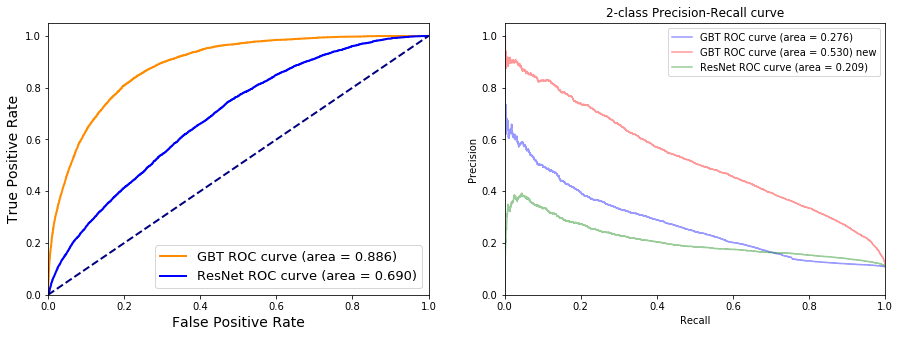

In [26]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
precision, recall, threshold_pr = precision_recall_curve(Y_test, y_pred_xgb_prob_best_[:,1],pos_label=1)
precision3, recall3, threshold_pr3 = precision_recall_curve(Y_test, y_pred_xgb_prob_best[:,1],pos_label=1)

ftp,tpr,threshold_roc = roc_curve(Y_test,y_pred_xgb_prob_best[:,1],pos_label=1)

precision2, recall2, threshold_pr2 = precision_recall_curve(Y_test, y_pred[:,1])

ftp2,tpr2,threshold_roc2 = roc_curve(Y_test,y_pred[:,1])

fig,axes = subplots(1,2,figsize=(15,5))
ax = axes.ravel()
ax[0].plot(ftp, tpr, color='darkorange',
         lw=2, label='GBT ROC curve (area = %0.3f)' % auc(ftp,tpr))
ax[0].plot(ftp2, tpr2, color='blue',
        lw=2, label='ResNet ROC curve (area = %0.3f)' % auc(ftp2,tpr2))

ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate',fontsize=14)
ax[0].set_ylabel('True Positive Rate',fontsize=14)
ax[0].legend(loc="lower right",fontsize=13)

thresholds = np.append(threshold_pr, 1)
f1_scores = 2*(precision*recall)/(precision+recall)

ax[1].plot(recall, precision, color='b', alpha=0.4,label='GBT ROC curve (area = %0.3f)' % auc(recall,precision))
ax[1].plot(recall3, precision3, color='r', alpha=0.4,label='GBT ROC curve (area = %0.3f) new' % auc(recall3,precision3))
ax[1].plot(recall2, precision2, color='g', alpha=0.4,label='ResNet ROC curve (area = %0.3f)' % auc(recall2,precision2))

ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlim([0.0, 1.0])
ax[1].set_title('2-class Precision-Recall curve')
ax[1].legend()